In [36]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')

# Show all columns in the DataFrame
pd.set_option('display.max_columns', None)

# Checks GPU availability and sets the device to GPU (or CPU)

# Check number of GPUs
num_gpus = torch.cuda.device_count()
print("Number of GPU(s):", num_gpus)

# Check GPU name
if num_gpus > 0:
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("No GPU found.")

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU(s): 1
GPU Name: NVIDIA GeForce RTX 3070 Ti
Using device: cuda


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\royle\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


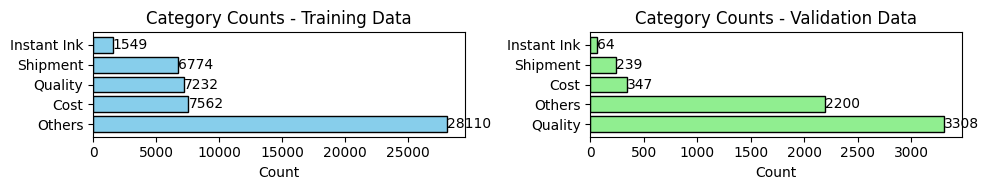

In [65]:
df = pd.read_csv('combined_dfv2.csv', dtype=str)

# 'max_predicted_aspect'  : Ground Truth Aspects / Labels
# 'Combined Text'         : Review Content for Aspect Predictions / Texts

### Data Preparation Steps for Model Training Data
# 1.1 Removal of NaN from Labels and Texts                  ✔️
# 1.2 Renaming of Labels, Product/print Quality -> Quality  ✔️
# 2.1 Creating measure for Token and Sentence Count         ✔️
# 2.2 Filter by Review Length or Tokens                     ✔️
# 3. Filter by Date,  Training: <Apr-24, Validation: Apr-24)✔️

# 1.1 Removal of NaN from Labels and Texts
df = df.dropna(subset=['max_predicted_aspect', 'Combined Text'])

# 1.2 Renaming of Labels, Product/print Quality -> Quality
df['max_predicted_aspect'] = df['max_predicted_aspect'].replace({'Product/print quality': 'Quality'})

# 2.1 Creating measure for Token and Sentence Count
def count_tokens(text):
    if isinstance(text, str):  # Only process string values
        return len(text.split())
    return 0  # Return 0 for non-string or NaN values
df['token_count'] = df['Combined Text'].apply(count_tokens)

def count_sentences(text):
    return len(nltk.sent_tokenize(text))
df['sentence_count'] = df['Combined Text'].apply(count_sentences)

# 2.2 Filter by Review Length and/or Tokens
token_threshold = 40
sentence_threshold = 3
df = df[(df['token_count'] <= token_threshold) | (df['sentence_count'] <= sentence_threshold)]

# 3. Filter by Date,  Training: <Apr-24, Validation: Apr-24)
mmm_yy1 = 'Jun-23'
mmm_yy2 = 'Apr-24'
df['date'] = pd.to_datetime(df['Month of Response Date'], format='%b-%y')
cutoff_date1 = pd.to_datetime(mmm_yy1, format='%b-%y')
cutoff_date2 = pd.to_datetime(mmm_yy2, format='%b-%y')

training_df = df[(df['date'] >= cutoff_date1) | (df['date'] < cutoff_date2)].sort_values('date', ascending=False)
validation_df = df[df['date'] == cutoff_date2]


### Plotting bar chart for visual inspection and comparison

# Get value counts for each category in training_df and validation_df
training_value_counts = training_df['max_predicted_aspect'].value_counts()
validation_value_counts = validation_df['max_predicted_aspect'].value_counts()

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 2))

# Plotting the bar chart for training_df
axes[0].barh(training_value_counts.index, training_value_counts.values, color='skyblue', edgecolor='black')
for i in range(len(training_value_counts)):
    axes[0].text(training_value_counts.values[i], i, training_value_counts.values[i], va='center')
axes[0].set_xlabel('Count')
axes[0].set_title('Category Counts - Training Data')

# Plotting the bar chart for validation_df
axes[1].barh(validation_value_counts.index, validation_value_counts.values, color='lightgreen', edgecolor='black')
for i in range(len(validation_value_counts)):
    axes[1].text(validation_value_counts.values[i], i, validation_value_counts.values[i], va='center')
axes[1].set_xlabel('Count')
axes[1].set_title('Category Counts - Validation Data')

# Adjust layout
plt.tight_layout()
plt.show()

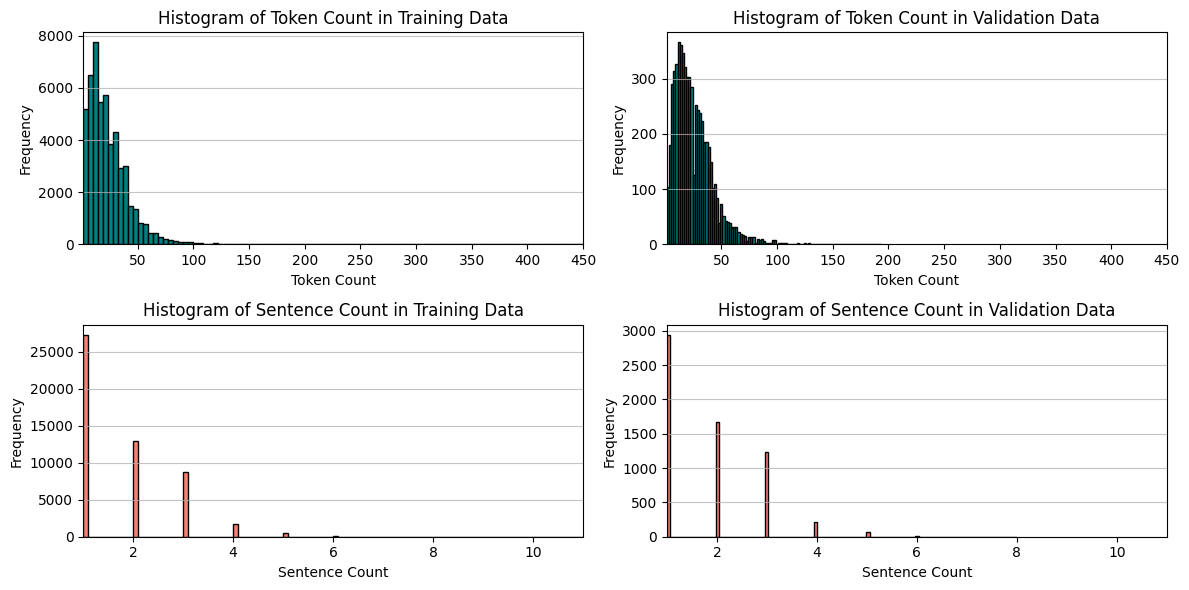

In [72]:
# Create subplots: 2 rows and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

# Calculate min and max for token_count and sentence_count
min_token_count = min(training_df['token_count'].min(), validation_df['token_count'].min())
max_token_count = max(training_df['token_count'].max(), validation_df['token_count'].max())

min_sentence_count = min(training_df['sentence_count'].min(), validation_df['sentence_count'].min())
max_sentence_count = max(training_df['sentence_count'].max(), validation_df['sentence_count'].max())

# Plotting the token count histogram for training data
axes[0, 0].hist(training_df['token_count'], bins=100, color='Teal', edgecolor='black')
axes[0, 0].set_xlabel('Token Count')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Histogram of Token Count in Training Data')
axes[0, 0].set_xlim(min_token_count, max_token_count)  # Set x-axis limits
axes[0, 0].grid(axis='y', alpha=0.75)

# Plotting the sentence count histogram for training data
axes[1, 0].hist(training_df['sentence_count'], bins=100, color='Salmon', edgecolor='black')
axes[1, 0].set_xlabel('Sentence Count')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Histogram of Sentence Count in Training Data')
axes[1, 0].set_xlim(min_sentence_count, max_sentence_count)  # Set x-axis limits
axes[1, 0].grid(axis='y', alpha=0.75)

# Plotting the token count histogram for validation data
axes[0, 1].hist(validation_df['token_count'], bins=100, color='Teal', edgecolor='black')
axes[0, 1].set_xlabel('Token Count')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Histogram of Token Count in Validation Data')
axes[0, 1].set_xlim(min_token_count, max_token_count)  # Set x-axis limits
axes[0, 1].grid(axis='y', alpha=0.75)

# Plotting the sentence count histogram for validation data
axes[1, 1].hist(validation_df['sentence_count'], bins=100, color='Salmon', edgecolor='black')
axes[1, 1].set_xlabel('Sentence Count')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Histogram of Sentence Count in Validation Data')
axes[1, 1].set_xlim(min_sentence_count, max_sentence_count)  # Set x-axis limits
axes[1, 1].grid(axis='y', alpha=0.75)

# Adjust layout
plt.tight_layout()
plt.show()

C:\Users\royle\AppData\Local\Temp\ipykernel_14712\1857272605.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = training_df.groupby('max_predicted_aspect').apply(lambda x: x.sample(n=n_sample, random_state=93)).reset_index(drop=True)


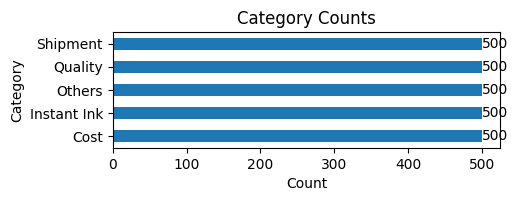

In [79]:
# sample equal no. of records from each label
n_sample = 500
sampled_df = training_df.groupby('max_predicted_aspect').apply(lambda x: x.sample(n=n_sample, random_state=93)).reset_index(drop=True)      #random sampling
sampled_df = training_df.groupby('max_predicted_aspect').apply(lambda x: x.nsmallest(n=n_sample, columns='index')).reset_index(drop=True)   #most recent 

value_counts = sampled_df['max_predicted_aspect'].value_counts()

# horizontal bar chart plot
plt.figure(figsize=(5, 1.5))
ax = value_counts.plot(kind='barh')
for i in ax.containers:
    ax.bar_label(i)

plt.xlabel('Count')
plt.ylabel('Category')
plt.title('Category Counts')
plt.show()

In [7]:
# filtered_df
# sample_df
df = filtered_df

# text input : Combined Text
# label ouput : max_predicted_aspect

data_texts = df['Combined Text'].to_list() # text 

from sklearn.preprocessing import LabelEncoder
# Convert labels to numeric categories
label_encoder = LabelEncoder()

data_labels = df['max_predicted_aspect'].to_list()  # Original labels
data_labels = label_encoder.fit_transform(data_labels)  # Numeric labels

# Get the mapping of original labels to numeric labels
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

# Print the mapping
print("Label Mapping:")
print(label_mapping)

Label Mapping:
{'Cost': 0, 'Instant Ink': 1, 'Others': 2, 'Quality': 3, 'Shipment': 4}


In [28]:
import torch
import numpy as np 
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import Dataset
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

# Load tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Split data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size=0.2, random_state=42)

# Create a PyTorch Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TextDataset(train_texts, train_labels, tokenizer)
val_dataset = TextDataset(val_texts, val_labels, tokenizer)

# Load model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

# Define compute_metrics function to calculate accuracy, precision, recall, and f1
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Set device
if torch.cuda.is_available():
    model.cuda()

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results', # directory where model checkpoints, configuration files, tokenizer files, and training logs will be saved during and after the training process
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="no",
    save_strategy="no",
    load_best_model_at_end=False,
    logging_steps=10,
    gradient_accumulation_steps=4
)

# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()


# Save the model, tokenizer, and training arguments to the output directory
model.save_pretrained('./distilbert aspect classification test')
tokenizer.save_pretrained('./distilbert aspect classification test')

C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\train

  0%|          | 0/505 [00:00<?, ?it/s]

{'loss': 1.5818, 'grad_norm': 3.047511339187622, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.1}
{'loss': 1.5724, 'grad_norm': 2.578470468521118, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.2}
{'loss': 1.5386, 'grad_norm': 2.7158443927764893, 'learning_rate': 3e-06, 'epoch': 0.29}
{'loss': 1.4933, 'grad_norm': 2.953618288040161, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.39}
{'loss': 1.4086, 'grad_norm': 3.0936591625213623, 'learning_rate': 5e-06, 'epoch': 0.49}
{'loss': 1.2779, 'grad_norm': 2.406714677810669, 'learning_rate': 6e-06, 'epoch': 0.59}
{'loss': 1.1588, 'grad_norm': 1.6756728887557983, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.69}
{'loss': 1.0759, 'grad_norm': 1.1815372705459595, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.79}
{'loss': 1.0419, 'grad_norm': 1.7123138904571533, 'learning_rate': 9e-06, 'epoch': 0.88}
{'loss': 1.0281, 'grad_norm': 0.9328864216804504, 'learning_rate': 1e-05, 'epoch': 0.98}
{'loss': 1.0352, 'grad_norm': 1.59

('./distilbert aspect classification test\\tokenizer_config.json',
 './distilbert aspect classification test\\special_tokens_map.json',
 './distilbert aspect classification test\\vocab.txt',
 './distilbert aspect classification test\\added_tokens.json')

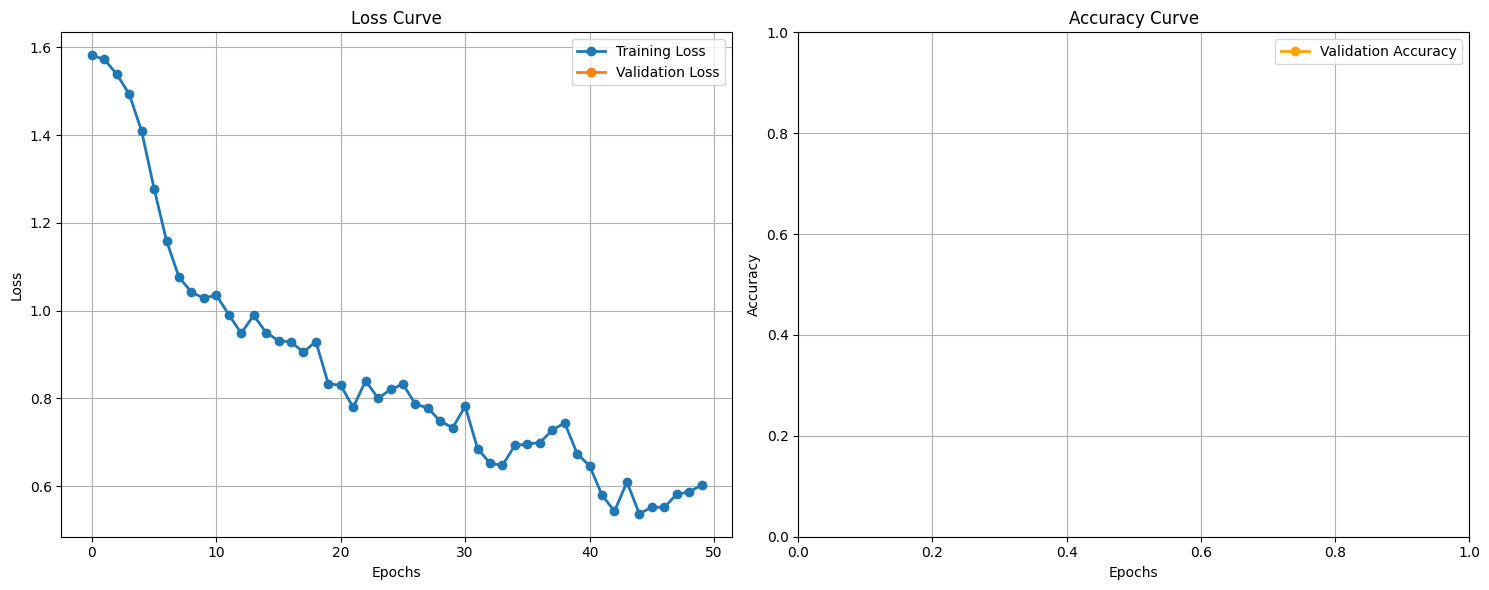

In [37]:
def plot_training_curves(trainer):
    # Access the logs
    logs = trainer.state.log_history

    # Create lists to hold the loss and accuracy values
    train_loss = []
    eval_loss = []
    eval_accuracy = []

    # Iterate through the logs and collect loss and accuracy values
    for log in logs:
        if 'loss' in log:
            train_loss.append(log['loss'])
        if 'eval_loss' in log:
            eval_loss.append(log['eval_loss'])
        if 'eval_accuracy' in log:
            eval_accuracy.append(log['eval_accuracy'])

    # Define the epochs (x-axis values)
    epochs = range(1, len(eval_accuracy) + 1)  # Ensure the x-axis matches the number of epochs

    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))  # Change to 1 row and 2 columns

    # Plot loss
    axs[0].plot(train_loss, label='Training Loss', marker='o', markersize=6, linestyle='-', linewidth=2)
    axs[0].plot(eval_loss, label='Validation Loss', marker='o', markersize=6, linestyle='-', linewidth=2)
    axs[0].set_title('Loss Curve')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid()

    # Plot accuracy
    axs[1].plot(epochs, eval_accuracy, label='Validation Accuracy', color='orange', marker='o', markersize=6, linestyle='-', linewidth=2)
    axs[1].set_title('Accuracy Curve')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlim(0, 1)  # Set x-axis from 0 to total epochs
    axs[1].set_ylim(0, 1) 
    axs[1].legend()
    axs[1].grid()

    plt.tight_layout()
    plt.show()

# Call the function to plot training curves
plot_training_curves(trainer)


In [75]:
df

,Survey ID,Product Name,Print Customer Region,LTR,Source Type,Survey language,Review Source,Star Rating,Product Family,Supplies Family,...,Combined Text,Ink Supply Type,token_count,Month of Response Date,predicted_level1,predicted_probabilities,max_predicted_probability,max_predicted_level1,max_predicted_aspect,Predicted Category
18,110020182,HP 63 Black Original Ink Cartridge,US,10,Web Reviews,English,Walmart,5,Supplies - Ink,Dolmen Refresh,...,"Excllent quality; easy to order, received prom...",IPH,7,Apr-24,"Logistic Handling, General satisfied","['0.8352197918762199', '0.7786848755893012']",0.880666667,Brand Loyalty,Others,Others
108,123460320,HP 65XL Black Original Ink Cartridge,US,10,Web Reviews,English,Walmart,5,Supplies - Ink,Dolmen Refresh,...,Great price and arrived even earlier than stated.,IPH,8,Apr-24,Logistic Handling,['0.7908739113381595'],0.796588235,Brand Loyalty,Others,Others
137,132417974,HP 65XL Black Original Ink Cartridge,US,10,Web Reviews,English,Walmart,5,Supplies - Ink,Dolmen Refresh,...,Ink gets used up way to quickly for the price ...,IPH,40,Apr-24,Others,['0'],0.903254902,Brand Loyalty,Others,Others
141,133472112,HP 64XL High Yield Tri-color Original Ink Cart...,US,10,Web Reviews,English,Walmart,5,Supplies - Ink,Centaur,...,"Price competitive with other sources, but deli...",IPH,43,Apr-24,"Cost, Customer experience & expectation, Logis...","['0.7706731637061431', '0.7121404761904764', '...",0.739930023,Brand Loyalty,Others,Quality
144,134550233,HP 65XL Black Original Ink Cartridge,US,2,Web Reviews,English,Walmart,1,Supplies - Ink,Dolmen Refresh,...,Don't know. Never received my order,IPH,6,Apr-24,"Logistic Handling, Logistic Handling","['0.7046579705350247', '0.7609086637218992']",0.797254902,Brand Loyalty,Others,Shipment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96589,388678367,HP 65 2-pack Black Original Ink Cartridges,US,2,Web Reviews,English,Amazon US,1,Supplies - Ink,Dolmen Refresh,...,"First, this product is NOT from the HP store. ...",IPH,117,Apr-24,"Brand Loyalty, Brand Loyalty","['0.713154761904762', '0.7659368989484836']",0.731165476,Printer Hardware/Printing issues,Others,Others
96772,61455602,HP 65XL Tri-color Original Ink Cartridge,US,10,Web Reviews,English,Walmart,5,Supplies - Ink,Dolmen Refresh,...,Good product. No less expensive substitute ava...,IPH,14,Apr-24,Cost,['0.935159834444992'],0.770229291,Printer Hardware/Printing issues,Cost,Cost
96844,82801475,HP 65XL Tri-color Original Ink Cartridge,US,10,Web Reviews,English,Walmart,5,Supplies - Ink,Dolmen Refresh,...,The item was what I was looking for and I love...,IPH,14,Apr-24,Others,['0'],0.743411797,Printer Hardware/Printing issues,Others,Others
96895,94738564,HP 952XL High Yield Magenta Original Ink Cartr...,US,10,Web Reviews,English,Walmart,5,Supplies - Ink,Supernesta,...,The best/expensive/ can buy new printer w/price,IIC,7,Apr-24,Others,['0'],0.866998581,Printer Hardware/Printing issues,Others,Cost


In [17]:
model_1 = './distilbert aspect classification' # all data 
model_2 = './distilbert aspect classification test' # 100 data points from each label category

model_n = model_1

# Load tokenizer
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.preprocessing import LabelEncoder

tokenizer = DistilBertTokenizer.from_pretrained(model_n)
model = DistilBertForSequenceClassification.from_pretrained(model_n, num_labels=5)

# Set device
if torch.cuda.is_available():
    model.cuda()

test_sentences = [
    "I am happy with the delivery.",
    "Great ink quality",
    "Excellent customer service!",
    "Expensive but good",
    "The packaging was damaged.",
    "Worth the money",
    "Great value for the price, I saved a lot compared to buying cartridges in stores.",
    "The Instant Ink service is convenient, but sometimes the ink arrives a little later than expected.",
    "The customer service team was really helpful when I had issues with my account.",
    "The print quality is sharp and vibrant, especially for photos and color documents.",
    "My shipment arrived faster than anticipated, well-packaged and in perfect condition.",
    "While the ink is affordable, I feel like I go through cartridges quicker than expected.",
    "I love how Instant Ink automatically ships new cartridges when I'm running low.",
    "The app is easy to use, but I wish it had more detailed tracking options for ink usage.",
    "The ink delivers consistent quality across different types of paper, even on glossy finishes.",
    "Delivery was on time, but it would be great to have an express shipping option for emergencies."
]

# Prepare a list to hold predicted categories
predicted_categories = []

# Process each test sentence
for test_sentence in test_sentences:
    # Tokenize the input sentence
    inputs = tokenizer(test_sentence, return_tensors="pt", truncation=True, padding=True)

    # Move inputs to the same device as the model
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # Model inference (prediction)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Get predicted label
    pred_label = torch.argmax(logits, dim=1).item()

    # Convert predicted label back to category
    predicted_category = label_encoder.inverse_transform([pred_label])[0]
    
    # Append the predicted category to the list
    predicted_categories.append(predicted_category)

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'Test Sentence': test_sentences,
    'Predicted Category': predicted_categories
})

# Print the label mapping and the results DataFrame
print("Label Mapping:")
print(label_mapping)

print("\nResults DataFrame:")
print(results_df)

Label Mapping:
{'Cost': 0, 'Instant Ink': 1, 'Others': 2, 'Quality': 3, 'Shipment': 4}

Results DataFrame:
                                        Test Sentence Predicted Category
0                       I am happy with the delivery.           Shipment
1                                   Great ink quality            Quality
2                         Excellent customer service!             Others
3                                  Expensive but good               Cost
4                          The packaging was damaged.             Others
5                                     Worth the money             Others
6   Great value for the price, I saved a lot compa...               Cost
7   The Instant Ink service is convenient, but som...            Quality
8   The customer service team was really helpful w...             Others
9   The print quality is sharp and vibrant, especi...            Quality
10  My shipment arrived faster than anticipated, w...           Shipment
11  While the ink

In [29]:
import pandas as pd
from sklearn.metrics import accuracy_score

# Initialize model, tokenizer, and label encoder outside the function
model_1 = './distilbert aspect classification' # all data 
model_2 = './distilbert aspect classification test' # 100 data points from each label category

model_n = model_1
tokenizer = DistilBertTokenizer.from_pretrained(model_n)
model = DistilBertForSequenceClassification.from_pretrained(model_n, num_labels=5)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Function to get predicted category for a single sentence
def predict_category(text):
    # Tokenize the input sentence
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

    # Move inputs to the same device as the model
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Model inference (prediction)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Get predicted label (index)
    pred_label = torch.argmax(logits, dim=1).item()

    # Convert predicted label back to category
    predicted_category = label_encoder.inverse_transform([pred_label])[0]
    
    return predicted_category

df = pd.read_csv('combined_dfv2.csv', dtype=str)

# remove NA from text and label columns
df = df.dropna(subset=['max_predicted_aspect', 'Combined Text'])

# filter sample eg. data only in Apr 24
df = df[(df['Month of Response Date'] == 'Apr-24') & (df['max_predicted_level1'] != 'Brand Loyalty')]
# rename category 'Quality'
df['max_predicted_aspect'] = df['max_predicted_aspect'].replace({'Product/print quality': 'Quality'})

# Apply the model to each sentence in the DataFrame's text column
df['Predicted Category'] = df['Combined Text'].apply(predict_category)

In [30]:
df

,Survey ID,Product Name,Print Customer Region,LTR,Source Type,Survey language,Review Source,Star Rating,Product Family,Supplies Family,...,Combined Text,Ink Supply Type,token_count,Month of Response Date,predicted_level1,predicted_probabilities,max_predicted_probability,max_predicted_level1,max_predicted_aspect,Predicted Category
9139,380747537,ENVY 6000 All-in-One Printer series,US,0,HPS Surveys,English,NaN,NaN,Supplies - Ink,Obelisk,...,"Not enough ink to start, was able to print 20 ...",IPH,73,Apr-24,Instant Ink related,['0.741355407092907'],0.716852326,Printer Hardware/Printing issues,Quality,Quality
9147,382403088,HP ENVY 6455e All-in-One Printer,CA,10,HPS Surveys,English,NaN,NaN,Supplies - Ink,Obelisk,...,Great program....the only negative I have as a...,IPH,136,Apr-24,"Customer experience & expectation, Logistic Ha...","['0.7369152530396593', '0.7182081450412331']",0.872041472,Printer Hardware/Printing issues,Quality,Quality
9150,383979783,HP ENVY 6420e All-in-One Printer,DE,3,HPS Surveys,German,NaN,NaN,Supplies - Ink,Obelisk,...,Positive:\r\n - I think the idea of Instant In...,IPH,237,Apr-24,"Instant Ink related, Printer Hardware/Printing...","['0.774543041272453', '0.8555690863475685']",0.767095368,Printer Hardware/Printing issues,Quality,Quality
65724,358458956,HP DeskJet 2755e All-in-One Printer,US,10,HPS Surveys,English,NaN,NaN,Supplies - Ink,Obelisk,...,I like this printer. Hopefully the trail of pr...,IPH,12,Apr-24,Others,['0'],0,Others,Others,Others
67931,360697737,HP DeskJet 2710e All-in-One Printer,GB,2,HPS Surveys,English,NaN,NaN,Supplies - Ink,Obelisk,...,I have tried to ask.fir help we have put new c...,IPH,124,Apr-24,Cost,['0.7423694697968766'],0,Others,Others,Others
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96589,388678367,HP 65 2-pack Black Original Ink Cartridges,US,2,Web Reviews,English,Amazon US,1,Supplies - Ink,Dolmen Refresh,...,"First, this product is NOT from the HP store. ...",IPH,117,Apr-24,"Brand Loyalty, Brand Loyalty","['0.713154761904762', '0.7659368989484836']",0.731165476,Printer Hardware/Printing issues,Others,Others
96772,61455602,HP 65XL Tri-color Original Ink Cartridge,US,10,Web Reviews,English,Walmart,5,Supplies - Ink,Dolmen Refresh,...,Good product. No less expensive substitute ava...,IPH,14,Apr-24,Cost,['0.935159834444992'],0.770229291,Printer Hardware/Printing issues,Cost,Cost
96844,82801475,HP 65XL Tri-color Original Ink Cartridge,US,10,Web Reviews,English,Walmart,5,Supplies - Ink,Dolmen Refresh,...,The item was what I was looking for and I love...,IPH,14,Apr-24,Others,['0'],0.743411797,Printer Hardware/Printing issues,Others,Others
96895,94738564,HP 952XL High Yield Magenta Original Ink Cartr...,US,10,Web Reviews,English,Walmart,5,Supplies - Ink,Supernesta,...,The best/expensive/ can buy new printer w/price,IIC,7,Apr-24,Others,['0'],0.866998581,Printer Hardware/Printing issues,Others,Cost


In [31]:
# Calculate accuracy for predicted_column1
accuracy1 = accuracy_score(df['max_predicted_aspect'], df['Predicted Category'])

# Print the accuracies
print(f"Accuracy of Predicted Column 1: {accuracy1:.2f}")

Accuracy of Predicted Column 1: 0.96


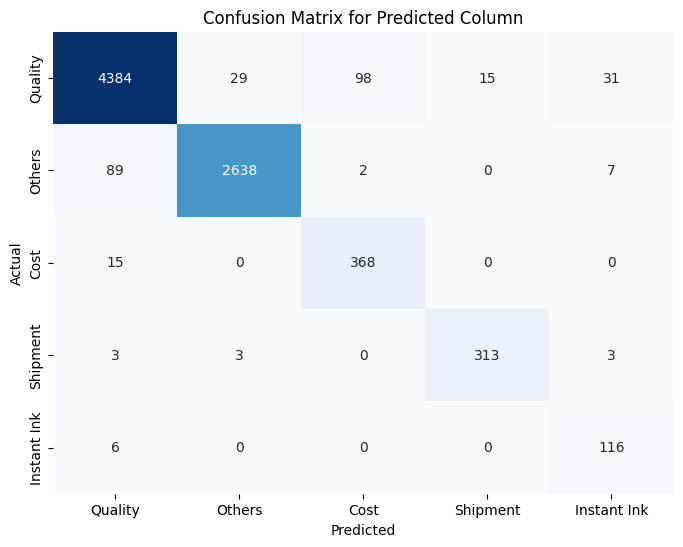

Accuracy per Category:
      Category  Accuracy Column
0      Quality         0.962036
1       Others         0.964181
2         Cost         0.960836
3     Shipment         0.972050
4  Instant Ink         0.950820


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix1 = confusion_matrix(df['max_predicted_aspect'], df['Predicted Category'], labels = df['max_predicted_aspect'].unique())
accuracy_per_category1 = np.diag(conf_matrix1) / conf_matrix1.sum(axis=1)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, categories, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=categories, yticklabels=categories)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_confusion_matrix(conf_matrix1, df['max_predicted_aspect'].unique(), title='Confusion Matrix for Predicted Column')

# Categories
categories = df['max_predicted_aspect'].unique()

# Create a DataFrame to show accuracies per category
accuracy_summary_df = pd.DataFrame({
    'Category': categories,
    'Accuracy Column': accuracy_per_category1
})

# Print the accuracy summary DataFrame
print("Accuracy per Category:")
print(accuracy_summary_df)

In [69]:
model_1 = './distilbert aspect classification' # all data 
model_2 = './distilbert aspect classification test' # 100 data points from each label category

model_n = model_2

# Load tokenizer
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.preprocessing import LabelEncoder

import pandas as pd
from sklearn.metrics import accuracy_score

# Function to get predicted category for a single sentence
def predict_category(text):

    tokenizer = DistilBertTokenizer.from_pretrained(model_n)
    model = DistilBertForSequenceClassification.from_pretrained(model_n, num_labels=5)

    # Tokenize the input sentence
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

    # Move inputs to the same device as the model
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # Model inference (prediction)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Get predicted label (index)
    pred_label = torch.argmax(logits, dim=1).item()

    # Convert predicted label back to category
    predicted_category = label_encoder.inverse_transform([pred_label])[0]
    
    return predicted_category

# Apply the model to each sentence in the DataFrame's text column
df['Predicted Category'] = df['Combined Text'].apply(predict_category)



KeyboardInterrupt: 

In [ ]:
# Calculate accuracy for predicted_column1
accuracy1 = accuracy_score(df['max_predicted_aspect'], df['Predicted Category'])

# Print the accuracies
print(f"Accuracy of Predicted Column 1: {accuracy1:.2f}")

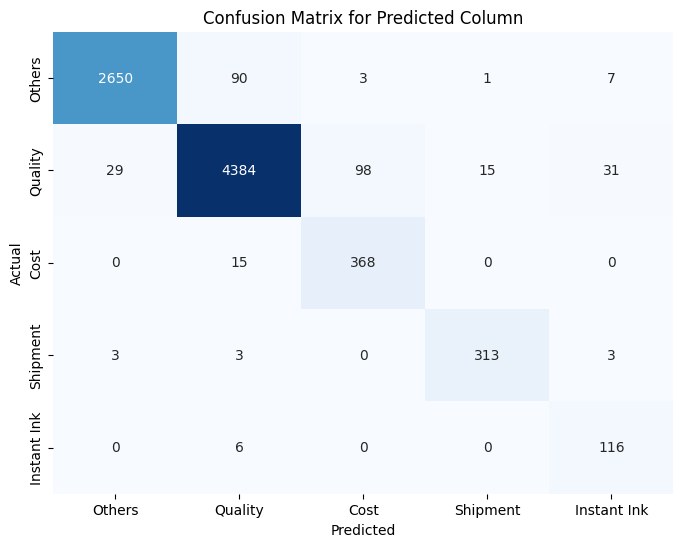

Accuracy per Category:
      Category  Accuracy Column
0       Others         0.963286
1      Quality         0.962036
2         Cost         0.960836
3     Shipment         0.972050
4  Instant Ink         0.950820


In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix1 = confusion_matrix(df['max_predicted_aspect'], df['Predicted Category'], labels = df['max_predicted_aspect'].unique())
accuracy_per_category1 = np.diag(conf_matrix1) / conf_matrix1.sum(axis=1)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, categories, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=categories, yticklabels=categories)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_confusion_matrix(conf_matrix1, df['max_predicted_aspect'].unique(), title='Confusion Matrix for Predicted Column')

# Categories
categories = df['max_predicted_aspect'].unique()

# Create a DataFrame to show accuracies per category
accuracy_summary_df = pd.DataFrame({
    'Category': categories,
    'Accuracy Column': accuracy_per_category1
})

# Print the accuracy summary DataFrame
print("Accuracy per Category:")
print(accuracy_summary_df)